In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import keras
import os
import math

from skimage import io, img_as_float
from skimage.feature import canny
from skimage.filters import threshold_isodata
from skimage.color import rgb2gray
from skimage.measure import label, regionprops
from skimage.transform import downscale_local_mean, hough_line, hough_line_peaks, estimate_transform, warp
from pathlib import Path
from ipywidgets import interact

%matplotlib inline

In [ ]:
# read an image from a path within the project directory, convert it to grayscale and downscale it
def read_grayscale_image(relative_path):
    path = Path('.') / relative_path
    return downscale_local_mean(rgb2gray(img_as_float(io.imread(str(path)))), (5,5))

# load all the images in a folder within the project directory
def load_folder(relative_path):
    path = Path('.') / relative_path
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    return [read_grayscale_image(f'{relative_path}/{img}') for img in files]

# plot a grayscale image
def plot(img):
    plt.imshow(img, vmin=0, vmax=1, cmap='gray')
    plt.axis('off')
    plt.show()

images = load_folder('images')

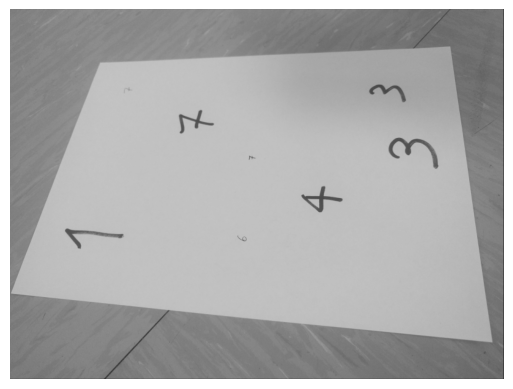

In [3]:
img = images[0]
plot(img)

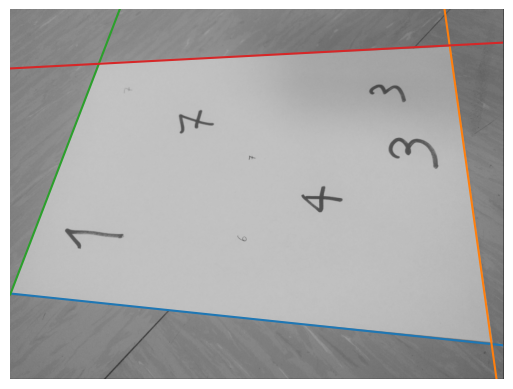

In [4]:
SIGMA = 1.5
HIGH_THRESHOLD = 0.5
LOW_THRESHOLD = 0
PEAK_THRESHOLD = 0

# Convert a hough line to a line in homogeneous coordinates
def hough_to_homogeneous_line(theta, distance):
    p1 = np.array([distance*np.cos(theta), distance*np.sin(theta)])
    linedir = np.array([np.cos(theta+np.pi/2), np.sin(theta+np.pi/2)])
    p0 = p1 - linedir * 1000
    p2 = p1 + linedir * 1000
    return np.cross([p0[0], p0[1], 1], [p2[0], p2[1], 1])

# Plot an image with a set of homogeneous lines on top of it
def plot_homogeneous_lines(img, lines):
    height, width = img.shape[:2]
    plt.imshow(img, vmin=0, vmax=1, cmap='gray')
    for line in lines:
        if line[1] != 0:
            x0, x1 = 0, width
            y0 = -(line[0]*x0 + line[2])/line[1]
            y1 = -(line[0]*x1 + line[2])/line[1]
        else:
            x0 = x1 = -line[2]/line[0]
            y0, y1 = 0, height
        plt.plot([x0, x1], [y0, y1], scalex=False, scaley=False)
    plt.axis('off')
    plt.show()

# Calculate the four most prominent lines in an image
def calculate_borders(img):
    edges = canny(img, sigma=SIGMA, high_threshold=HIGH_THRESHOLD, low_threshold=LOW_THRESHOLD)
    h_space, angles, dists = hough_line(edges)
    _, angles_peaks, dists_peaks = hough_line_peaks(h_space, angles, dists, threshold=PEAK_THRESHOLD, num_peaks=4)
    borders = [hough_to_homogeneous_line(theta, distance) for theta, distance in zip(angles_peaks, dists_peaks)]
    return borders

borders = calculate_borders(img)
plot_homogeneous_lines(img, borders)

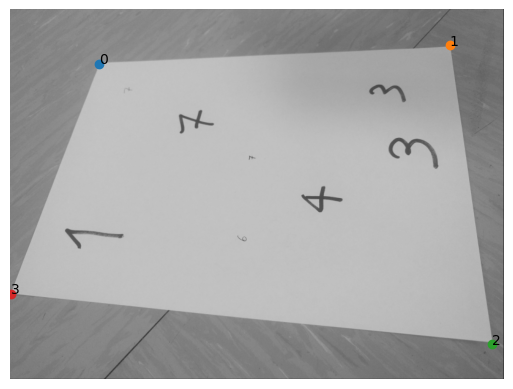

In [5]:
# Determine if a line in homogeneous coordinates is vertical based on its angle
def is_homogeneous_vertical(line):
    return abs(line[0]) > abs(line[1])

# Sort a set of cartesian points clockwise according to the centroid
def sort_cartesian_points(points):
    cx, cy = np.mean(points, axis=0) 
    angles = np.arctan2(points[:,1] - cy, points[:,0] - cx) 
    order = np.argsort(angles) 
    return points[order]

# Plot an image with a set of cartesian points on top of it
def plot_cartesian_points(img, points):
    fig, ax = plt.subplots()
    plt.imshow(img, vmin=0, vmax=1, cmap='gray')
    for i, point in enumerate(points):
        ax.plot(point[0], point[1], "o")
        ax.text(point[0], point[1], str(i))
    ax.set_axis_off()
    plt.show()

# Calculate the intersection between horizontal and vertical lines
def calculate_intersections(lines):
    vertical_lines = [line for line in lines if is_homogeneous_vertical(line)]
    horizontal_lines = [line for line in lines if not is_homogeneous_vertical(line)]
    intersections = []
    for vertical in vertical_lines:
        for horizontal in horizontal_lines:
            intersections += [np.cross(vertical, horizontal)]

    intersections_cartesian = np.array([[p[0]/p[2], p[1]/p[2]] for p in intersections])
    return sort_cartesian_points(intersections_cartesian)

intersections = calculate_intersections(borders)
plot_cartesian_points(img, intersections)

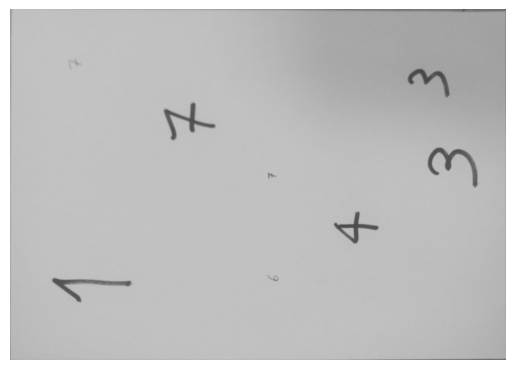

In [6]:
# Determine if a sheet is in vertical view if the avg width is less than the avg height
def is_vertical_sheet(points):
    width = np.mean([np.linalg.norm(points[0] - points[1]), np.linalg.norm(points[2] - points[3])]) 
    height = np.mean([np.linalg.norm(points[1] - points[2]), np.linalg.norm(points[3] - points[0])])
    return width < height

# Straighten a rectangle with the dimensions of a sheet of paper
def straighten(img, intersections):
    # Size of a sheet of paper with 10px per mm
    w = 2100 if is_vertical_sheet(intersections) else 2970
    h = 2970 if is_vertical_sheet(intersections) else 2100

    # Points to map the corners of the sheet
    A = np.array([0,0])
    B = np.array([w,0])
    C = np.array([w,h])
    D = np.array([0,h])

    inverse = estimate_transform("projective", src=np.vstack((A,B,C,D)), dst=np.vstack(intersections))
    return warp(image=img, inverse_map=inverse, output_shape=(h,w))

img_transform = straighten(img, intersections)
plot(img_transform)

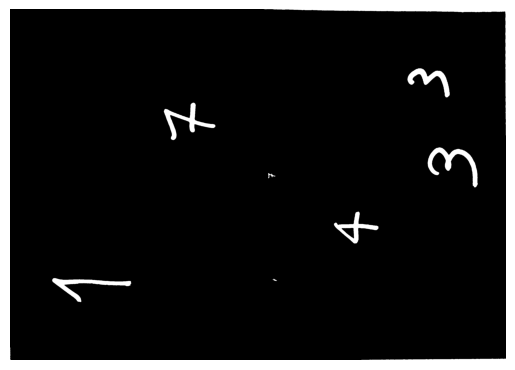

In [7]:
# Binarize an image
def binarize(img):
    threshold = threshold_isodata(img)
    img_binary = img < threshold
    return ski.morphology.remove_small_objects(img_binary, min_size=50)

img_binary = binarize(img_transform) 
plot(img_binary)

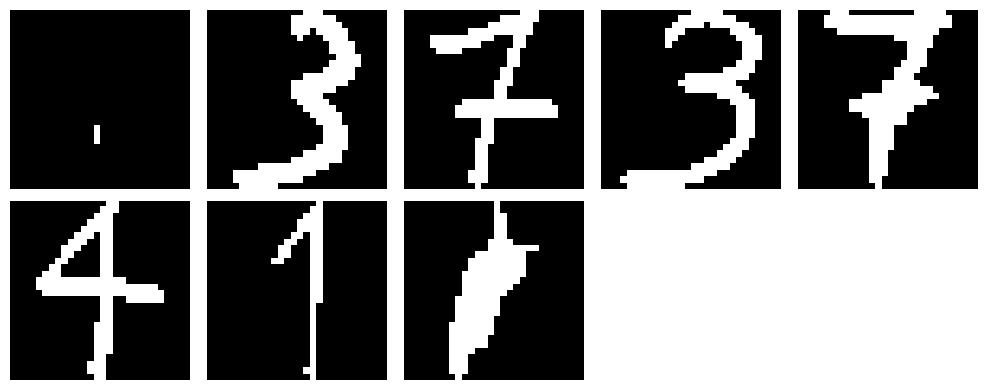

In [8]:
# Pad an image with 0s to make it square
def make_square(img):
    h, w = img.shape
    size = max(h, w)
    padded = np.zeros((size, size), dtype=img.dtype)
    y_off = (size - h) // 2
    x_off = (size - w) // 2
    padded[y_off:y_off+h, x_off:x_off+w] = img
    return padded

# Extract connected components in vertical orientation
def extract_connected_components(img):
    labels = label(img, connectivity=2)
    props = regionprops(labels)

    components = []
    total_width = 0
    total_height = 0
    for prop in props:
        minr, minc, maxr, maxc = prop.bbox
        height = maxr - minr
        width = maxc - minc
        aspect = height / width if width > 0 else 0
        if 0.2 < aspect < 5:
            total_width += width
            total_height += height
            component = img[minr:maxr, minc:maxc]    
            components.append(component)

    are_vertical = total_height / len(components) >= total_width / len(components)
    return [np.rot90(component, k=-1) for component in components] if not are_vertical else components

# Convert images to 28x28 squares
def preprocess_components(imgs):
    squares = [make_square(img) for img in imgs]
    return [ski.transform.resize(img, (28, 28), anti_aliasing=False) for img in squares]

# Plot a list of images
def plot_list(imgs):
    cols = 5
    rows = math.ceil(len(imgs) / cols)
    plt.figure(figsize=(10, 2 * rows))
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, vmin=0, vmax=1, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

components = extract_connected_components(img_binary)
digits = preprocess_components(components)
plot_list(digits)

In [9]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8924 - loss: 0.3579 - val_accuracy: 0.9790 - val_loss: 0.0794
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.9660 - loss: 0.1114 - val_accuracy: 0.9828 - val_loss: 0.0580
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9738 - loss: 0.0853 - val_accuracy: 0.9873 - val_loss: 0.0474
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.9775 - loss: 0.0716 - val_accuracy: 0.9892 - val_loss: 0.0424
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9803 - loss: 0.0642 - val_accuracy: 0.9885 - val_loss: 0.0412
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9823 - loss: 0.0582 - val_accuracy: 0.9912 - val_loss: 0.0349
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9823 - loss: 0.0559 - val_accuracy: 0.9900 - val_loss: 0.0356
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9849 - loss: 0.0489 - val_a

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.026050299406051636
Test accuracy: 0.9902999997138977


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


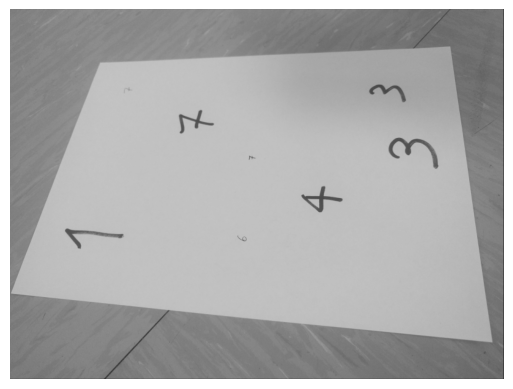

1, 1, 2, 3, 3, 4, 5, 7


In [13]:
DIGITS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Predict the digit represented by a each image
def predict(digits):
    predictions = model.predict(np.array(digits))
    predicted = []
    for prediction in predictions:
        predicted += [DIGITS[np.argmax(prediction)]]
    return sorted(predicted)

prediction = predict(digits)
plot(img)
print(', '.join(map(str, prediction)))

In [ ]:
images = load_folder('images')
predictions = []
for i, img in enumerate(images):
    try: 
        borders = calculate_borders(img)
        intersections = calculate_intersections(borders)
        img_transform = straighten(img, intersections)
        img_binary = binarize(img_transform) 
        components = extract_connected_components(img_binary)
        digits = preprocess_components(components)
        prediction = predict(digits)
        predictions += [prediction]
        print(prediction)
    except:
        predictions += ['Failed']
        print(f'Failed Image #{i}')
        continue

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[1, 1, 2, 3, 3, 4, 5, 7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[1, 1, 1, 2, 3, 3, 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[1, 1, 1, 3, 3, 4, 5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[1, 2, 3, 3, 4, 5, 5, 6, 7, 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0, 1, 2, 4, 5, 5, 5, 7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[2, 3, 4, 5, 5, 5, 7]
Failed Image #6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[1, 1, 1, 1, 2, 3, 3, 3, 5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[0, 2, 2, 3, 3, 4, 4, 7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 4, 5, 8, 8]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[1, 1, 1, 2, 3, 3, 4]
Failed Image #12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[1, 1, 2, 3, 3, 3, 4, 4, 4, 6, 7]
Failed Image #14
Failed Image #15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[1, 3, 3, 4, 5, 5, 6, 7, 7, 7]
Failed Image #17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0]
Failed Image #19
1/1 ━━━━━━━━━━━━━━━━━━━

In [19]:
@interact(i=(0, len(images)-1))
def show_image(i=0):
    plt.imshow(images[i], vmin=0, vmax=1, cmap='gray')
    plt.title(predictions[i])
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=20), Output()), _dom_classes=('widget-interact',…